# Demo notebook for how to study kHz motor data, partitioned over time according to machining steps
The goal here is to first turn the raw modal and partcount data into an index table of "machining steps." This will then be suitable for programmatically slicing out chunks of kHz data. We can then plot individual slices and/or compute various time series features.

## Import packages, customize plot settings

In [1]:
"""
Missing any packages on your system? Uncomment these lines to install
Depending on your jupyter environment setup, you may need to replace `pip` -> `conda`
"""
# import sys
# !{sys.executable} -m pip install "numpy>=1.18.1"
# !{sys.executable} -m pip install "pandas>=1.0.1"
# !{sys.executable} -m pip install "matplotlib>=3.1.3"
# !{sys.executable} -m pip install "seaborn>=0.10.0"

import numpy as np
import pandas as pd
from time import time, sleep
from IPython.display import display, clear_output

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 16

def bigplot(xsize=16, ysize=5):
    return plt.subplots(figsize=(xsize, ysize))

## Specify which data we'll load in
For this demo, we'll just assume that you downloaded and unzipped some csv files. Change as needed.

In [2]:
data_dir = 'data'
khz_file_names = [
    '2024-02-01T07-08-40Z_2024-02-01T07-38-43Z_khz.csv.gz',
]
modal_file_names = [
    '2024-02-01T07-04-48Z_2024-02-01T07-34-48Z_modal.csv.gz',
]
partcount_file_names = [
    '2024-02-01T07-04-48Z_2024-02-01T07-34-49Z_partcount.csv.gz',
]

## Load the dense kHz time series and lightly groom it

,load,speed
timestamp,,
2024-02-01 07:08:40.340266+00:00,0.0,-0.5
2024-02-01 07:08:40.341265+00:00,0.0,0.0
2024-02-01 07:08:40.342264+00:00,0.0,-0.5
2024-02-01 07:08:40.343263+00:00,0.0,-0.5
2024-02-01 07:08:40.344262+00:00,0.0,0.0
...,...,...
2024-02-01 07:38:43.947577+00:00,0.0,0.0
2024-02-01 07:38:43.948577+00:00,0.0,-0.5
2024-02-01 07:38:43.949577+00:00,0.0,0.0


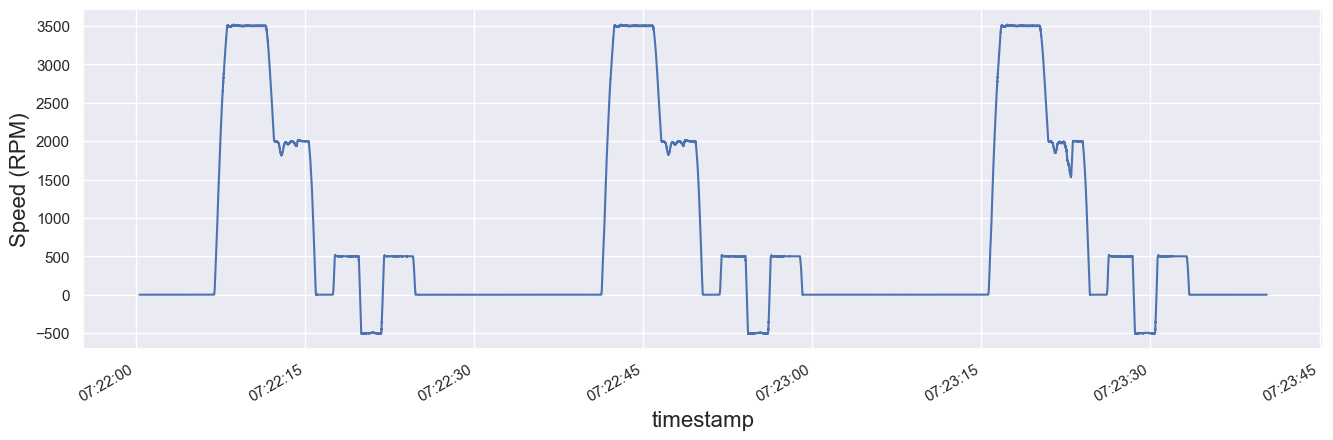

In [3]:
df_khz = (
    pd.concat([
        pd.read_csv(f"{data_dir}/{file_name}", comment='#')
        .rename(columns={
            'PATH-1 NAME-SS SPINDLE-1 torque command':'load',
            'PATH-1 NAME-SS SPINDLE-1 motor speed':'speed'
        })
        [['timestamp', 'load', 'speed']]
        for file_name in khz_file_names
    ])
    .assign(
        timestamp=lambda dfx: pd.to_datetime(dfx['timestamp']),  # timestamp strings -> pandas timestamps
        load=lambda dfx: dfx['load'] * 150 / 16384  # convert to "human-readable" load (% continuous rating)
    )  
    .sort_values('timestamp')  # just in case files were loaded out-of-order!
    .set_index('timestamp')
)
t_start, t_end = df_khz.index[0], df_khz.index[-1]
display(df_khz)
bigplot()
df_khz.iloc[800000:900000]['speed'].plot()
plt.ylabel('Speed (RPM)')
plt.show()

## Load modal and partcount data into a common machine-state dataframe, sorted by time

In [4]:
df_state = (
    pd.concat([
        pd.read_csv(f"{data_dir}/{file_name}", comment='#')
        .query('path == 1 and (key == "T" or key == "partcount")')
        for file_name in [*modal_file_names, *partcount_file_names]
    ])
    .assign(timestamp=lambda dfx: pd.to_datetime(dfx['timestamp']))  # timestamp strings -> pandas timestamps
    .sort_values('timestamp')
    .set_index('timestamp')
)
print("Long-format table of machine state evolution over time:")
display(df_state)

gr_state = df_state.groupby('key')['value']
for key in ['partcount', 'T']:
    df_state[key] = gr_state.transform(lambda gr: gr if gr.name == key else pd.NA)
print("Wide-format table of machine state evolution over time:")
display(df_state[['partcount', 'T']])

Long-format table of machine state evolution over time:


,path,key,value,ms_since_last_read,ms_api,ms_api_prev
timestamp,,,,,,
2024-02-01 07:04:49.631000+00:00,1,T,100.0,144,69,70
2024-02-01 07:04:49.703000+00:00,1,partcount,1093256.0,72,70,93
2024-02-01 07:20:18.057000+00:00,1,T,104.0,132,53,74
2024-02-01 07:20:21.635000+00:00,1,T,218.0,177,103,70
2024-02-01 07:20:26.449000+00:00,1,T,319.0,169,70,67
...,...,...,...,...,...,...
2024-02-01 07:26:43.562000+00:00,1,T,319.0,147,69,94
2024-02-01 07:26:49.386000+00:00,1,T,420.0,168,93,66
2024-02-01 07:26:58.813000+00:00,1,T,400.0,212,49,54


Wide-format table of machine state evolution over time:


,partcount,T
timestamp,,
2024-02-01 07:04:49.631000+00:00,<NA>,100.0
2024-02-01 07:04:49.703000+00:00,1093256.0,<NA>
2024-02-01 07:20:18.057000+00:00,<NA>,104.0
2024-02-01 07:20:21.635000+00:00,<NA>,218.0
2024-02-01 07:20:26.449000+00:00,<NA>,319.0
...,...,...
2024-02-01 07:26:43.562000+00:00,<NA>,319.0
2024-02-01 07:26:49.386000+00:00,<NA>,420.0
2024-02-01 07:26:58.813000+00:00,<NA>,400.0


## Machine state -> Machining steps
Derive start-time of each successive machining step, indexed by cycle # and tool #.

We'll treat everything as if on a single path.

Repeated tool numbers in the same cycle will be deduped in a simple way as follows: 404, 404, 404 -> 404.00, 404.01, 404.02

In [5]:
df_steps = (
    df_state
    .drop(columns=['path', 'key', 'value', 'ms since last read', 'ms_api', 'ms_api_prev'], errors='ignore')
    .ffill()
    .loc[lambda dfx: dfx.index != np.roll(dfx.index, -1)] # collapse redundant timestamps
    .loc[t_start:t_end]  # focus on kHz data time range
    .assign(cycle=lambda dfx:   # "cycle number" based on time range of interest
        (dfx['partcount'].diff() != 0)
        .fillna(False)
        .astype(int)
        .cumsum()
    )
    .assign(T=lambda dfx:  # elementary dedupe of repeated tool periods, e.g. 404, 404, 404 -> 404.00, 404.01, 404.02
        dfx
        .groupby(['cycle', 'T'])
        ['T']
        .transform(lambda x: x + 0.01 * np.arange(len(x)))
    )
    [['cycle', 'T']]
    .reset_index()  # pop out timestamp index -> column
    .set_index(['cycle', 'T'])
)
print("Machining steps as indexers for time:")
display(df_steps)

print("Available cycles:", df_steps.index.unique(level='cycle').to_list())
print("Available tools:", sorted(df_steps.index.unique(level='T').to_list()))

Machining steps as indexers for time:


timestamp
cycle T                                      
1     104.00 2024-02-01 07:20:18.057000+00:00
      218.00 2024-02-01 07:20:21.635000+00:00
      319.00 2024-02-01 07:20:26.449000+00:00
      420.00 2024-02-01 07:20:32.273000+00:00
      400.00 2024-02-01 07:20:41.829000+00:00
...                                       ...
12    319.00 2024-02-01 07:26:43.562000+00:00
      420.00 2024-02-01 07:26:49.386000+00:00
      400.00 2024-02-01 07:26:58.813000+00:00
      100.01 2024-02-01 07:26:59.093000+00:00
13    100.00 2024-02-01 07:27:00.485000+00:00

[84 rows x 1 columns]

Available cycles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Available tools: [100.0, 100.01, 104.0, 218.0, 319.0, 400.0, 420.0]


## Define the time slicing functions

In [6]:
def get_cycle(cycle):
    """
    Get a specific cycle from the kHz time series using efficient Pandas time slicing
    """
    if cycle not in df_steps.index.unique(level='cycle'):
        return df_khz.iloc[0:0]
    start_timestamp, end_timestamp = df_steps.loc[cycle, 'timestamp'].iloc[[0, -1]]
    if cycle + 1 in df_steps.index.unique(level='cycle'):
        end_timestamp = df_steps.loc[cycle + 1, 'timestamp'].iloc[0]
    return df_khz.loc[start_timestamp:end_timestamp]

def get_cycle_tool(cycle, T):
    """
    Get a specific cycle & tool use period from the kHz time series using efficient Pandas time slicing
    """
    if (cycle, T) not in df_steps.index:
        return df_khz.iloc[0:0]
    start_timestamp = df_steps.at[(cycle, T), 'timestamp']
    end_timestamp =  df_steps.shift(-1).at[(cycle, T), 'timestamp']
    return df_khz.loc[start_timestamp:end_timestamp] if pd.notna(end_timestamp) else df_khz.iloc[0:0]

## Test it out

2024-02-01 07:26:09.212000+00:00 thru 2024-02-01 07:26:15.006000+00:00


,load,speed
timestamp,,
2024-02-01 07:26:09.212307+00:00,12.734985,3500.0
2024-02-01 07:26:09.213307+00:00,13.467407,3498.5
2024-02-01 07:26:09.214308+00:00,14.071655,3499.5
2024-02-01 07:26:09.215309+00:00,14.666748,3498.5
2024-02-01 07:26:09.216310+00:00,15.179443,3499.0
...,...,...
2024-02-01 07:26:15.001244+00:00,-97.485352,1867.5
2024-02-01 07:26:15.002244+00:00,-97.485352,1867.0
2024-02-01 07:26:15.003243+00:00,-97.485352,1865.5


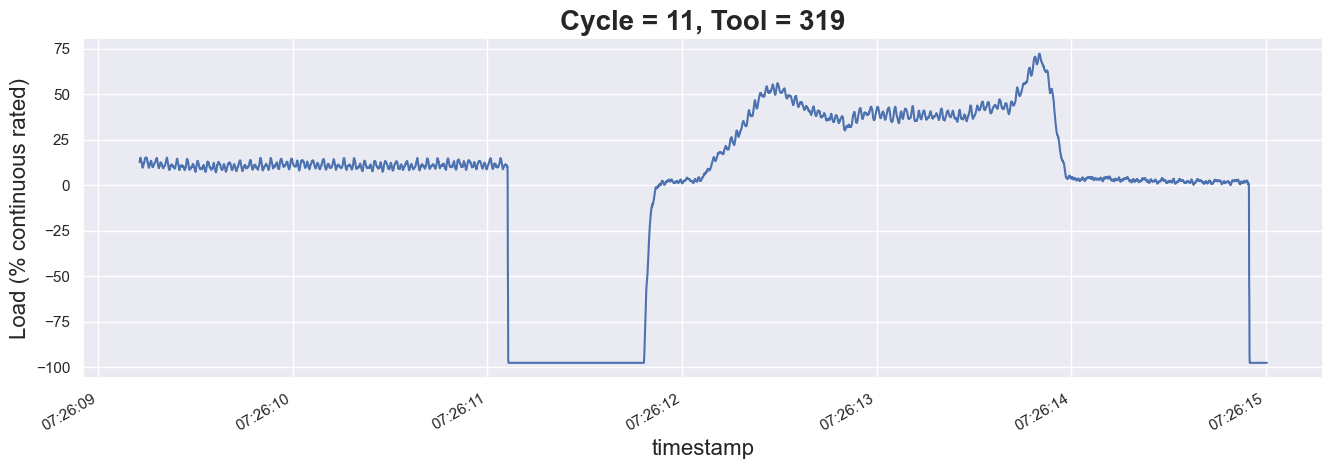

All of cycle 11:


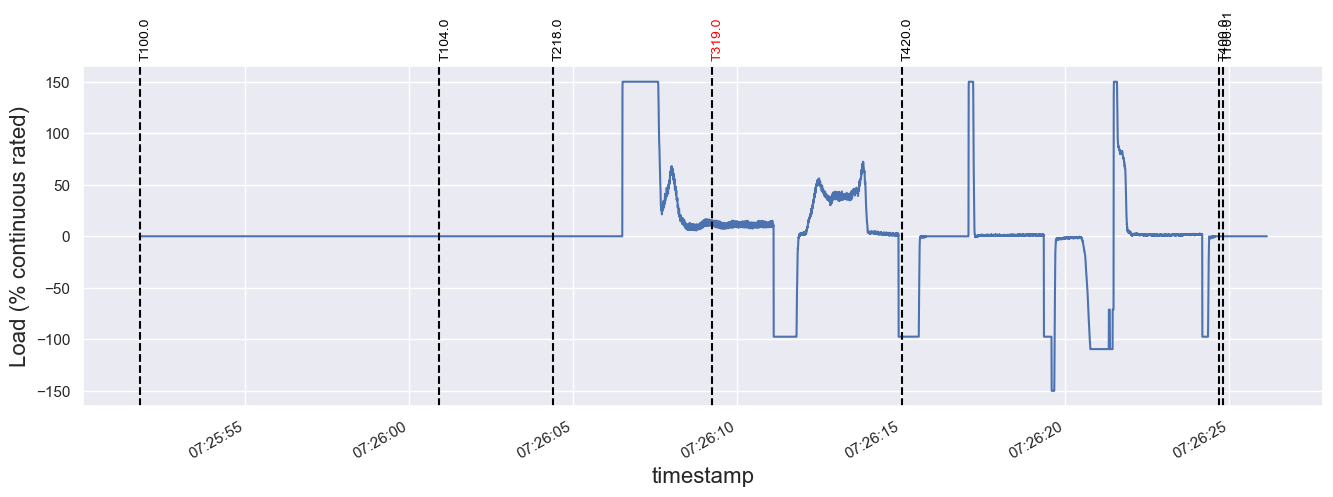

In [7]:
test_cycle, test_tool = 11, 319

print(df_steps.loc[(test_cycle, test_tool)]['timestamp'], 'thru', 
      df_steps.shift(-1).loc[(test_cycle, test_tool)]['timestamp'])
dft = get_cycle_tool(test_cycle, test_tool)
display(dft)
bigplot()
dft['load'].plot()
plt.title(f'Cycle = {test_cycle}, Tool = {test_tool}')
plt.ylabel('Load (% continuous rated)')
plt.show()

print(f"All of cycle {test_cycle}:")
fix, ax = bigplot()
get_cycle(test_cycle)['load'].plot()
# plt.title(f'Cycle = {test_cycle}')
plt.ylabel('Load (% continuous rated)')
for tool in df_steps.loc[test_cycle].index:
    t_tool = df_steps.at[(test_cycle, tool), 'timestamp']
    color = 'black' if tool > 1.0 else '0.7'
    plt.axvline(t_tool, color=color, linestyle='--')
    if tool > 1.0:
        plt.text(t_tool, ax.get_ylim()[1]*1.05, f'T{tool}', 
                 color='red' if tool == test_tool else 'black', fontsize=10, rotation=90)
plt.show()

## Feature extraction per machining step

In [8]:
feature_rows = []
previous_cycle = 0
print("Working on cycle:", end=' ')
for cycle, T in df_steps.index:
    if cycle != previous_cycle:
        print(cycle, end=' ')
        previous_cycle = cycle
    dft = get_cycle_tool(cycle, T)
    feature_rows.append({
        'duration':len(dft),
        'load_integral':dft['load'].sum(),
        'load_median':dft['load'].median(),
        # INSERT WHATEVER ELSE YOU WANT HERE!
    })
print()
df_features = pd.DataFrame(index=df_steps.index, data=feature_rows)
display(df_features)

Working on cycle: 1 2 3 4 5 6 7 8 9 10 11 12 13 


duration  load_integral  load_median
cycle T                                           
1     104.00      3580       0.000000     0.000000
      218.00      4816  215333.898926    12.666321
      319.00      5826   96089.172363    12.213135
      420.00      9560  -32032.717896     0.823975
      400.00       132       0.000000     0.000000
...                ...            ...          ...
12    319.00      5802   20377.047729    11.114502
      420.00      9437 -137472.106934     0.677490
      400.00       280     -61.193848     0.000000
      100.01      1394       0.000000     0.000000
13    100.00         0       0.000000          NaN

[84 rows x 3 columns]

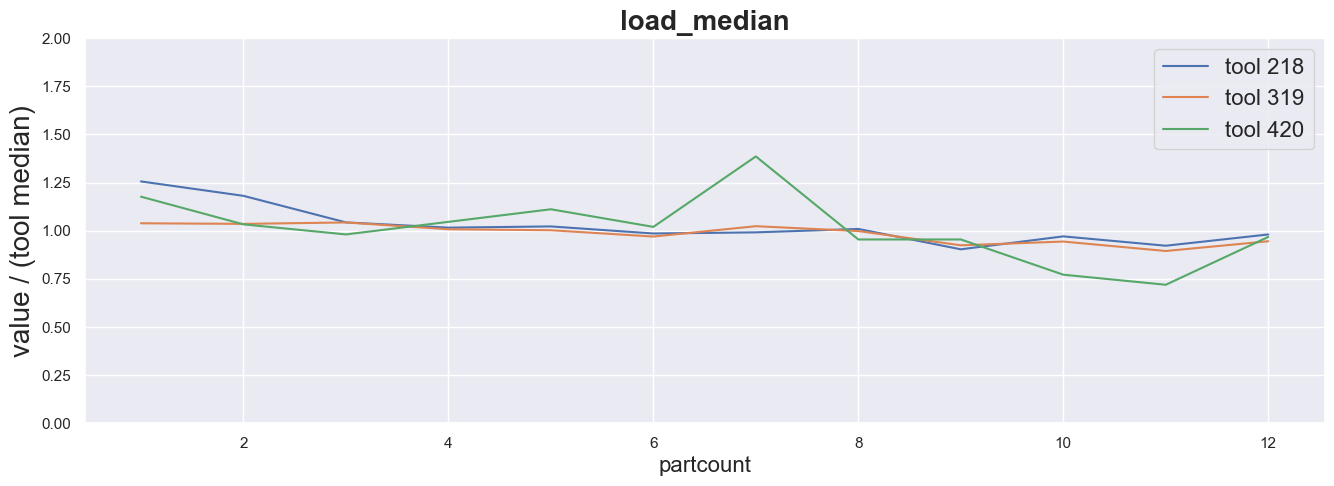

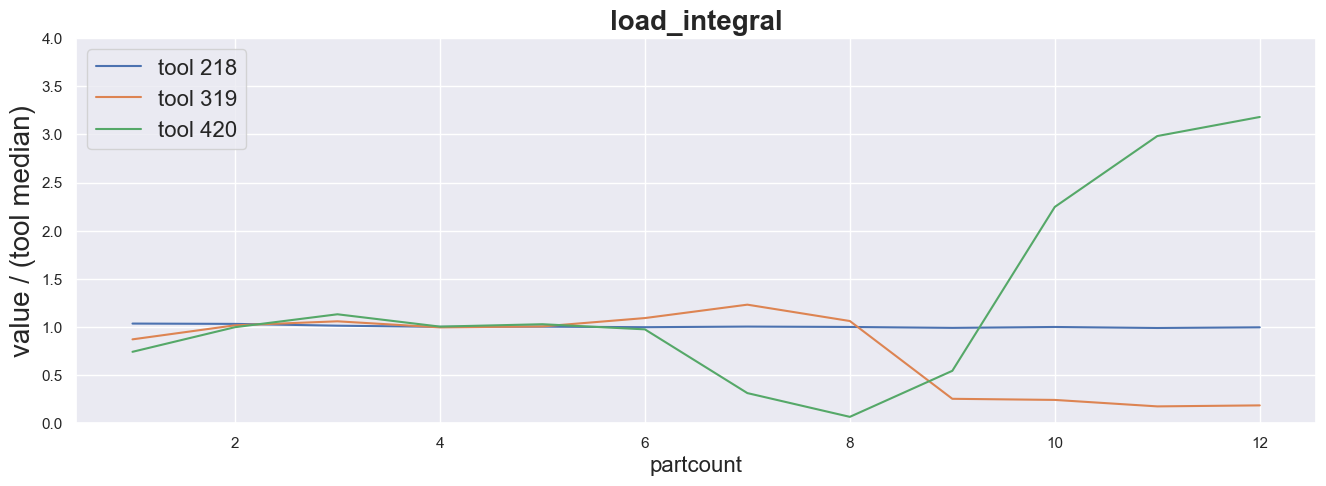

In [9]:
all_tools = filter(lambda x: x > 1.0, sorted(df_steps.index.unique(level='T').to_list()))

def plot_feature(feature, tools=all_tools, **plt_kwargs):
    """
    Plot a derived time series feature versus partcount
    Each tool use period is overlayed as a separate line
    Features are automatically normalized to the median per-tool
    """
    dft = df_features.swaplevel()
    fix, ax = bigplot()
    for T in tools:
        (dft.loc[T, feature] / dft.loc[T, feature].median()).plot(ax=ax, label=f'tool {T}', **plt_kwargs)
        ax.set_xlabel(f'partcount')
        ax.set_ylabel('value / (tool median)', fontsize=20)
    ax.set_title(feature)
    plt.gca().relim()
    plt.legend()
    plt.show()

test_tools = [218, 319, 420]
plot_feature('load_median', tools=test_tools, ylim=[0., 2])
plot_feature('load_integral', tools=test_tools, ylim=[0., 4])